## Average Monthly Consumption using z-score distribution

=== Removed Data Points (zeros + |z|>2.5 outliers) ===

        ds     y         z
2024-12-25  0.00 -2.677913
2025-01-28  3.48 -2.664843
2025-01-29  0.00 -2.677913
2025-01-30  0.00 -2.677913
2025-01-31 37.98 -2.535267
2025-02-03  0.00 -2.677913
2025-02-04  0.00 -2.677913
2025-02-05  0.00 -2.677913
2025-02-06  0.00 -2.677913
2025-02-07  0.00 -2.677913
2025-02-08  0.00 -2.677913
2025-03-30  0.00 -2.677913
2025-03-31  0.00 -2.677913

=== Monthly Avg Daily Consumption (RAW) ===
 Month_End  Avg_Daily_Consumption_Raw
2024-10-31                 827.091935
2024-11-30                 790.572333
2024-12-31                 728.790000
2025-01-31                 652.767097
2025-02-28                 556.647143
2025-03-31                 709.523226

=== Monthly Avg Daily Consumption (CLEANED) ===
 Month_End  Avg_Daily_Consumption_Cleaned
2024-10-31                     827.091935
2024-11-30                     790.572333
2024-12-31                     753.083000
2025-01-31                     747.937

C:\Users\umarul\AppData\Local\Temp\ipykernel_43464\3244297233.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')
C:\Users\umarul\AppData\Local\Temp\ipykernel_43464\3244297233.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


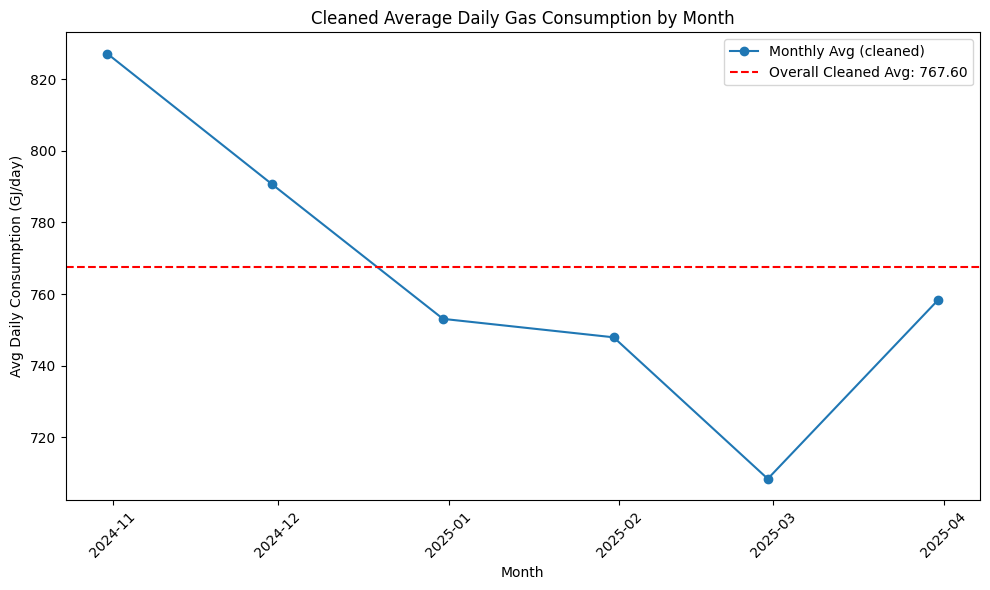

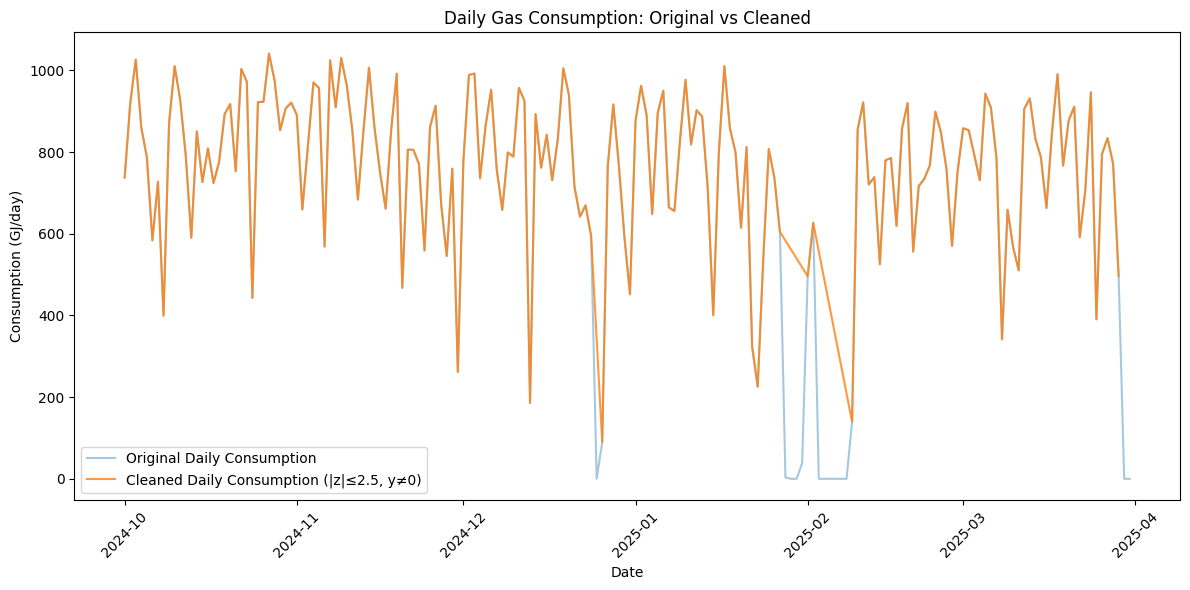

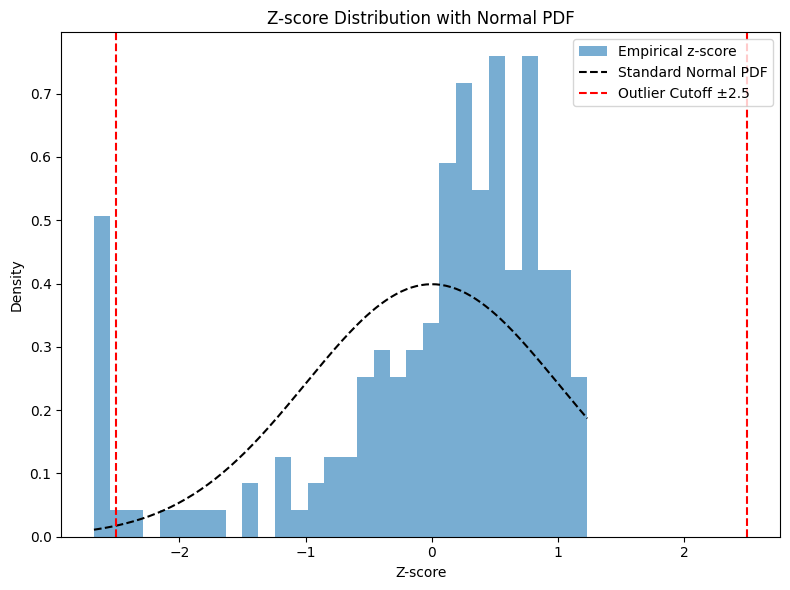

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# FULL SCRIPT: Clean & Analyze Gas Consumption
#   - Drops zero‐consumption days (holidays)
#   - Drops deep dips beyond ±2.5σ
#   - Prints removed points
#   - Prints monthly averages BEFORE and AFTER cleaning
#   - Prints overall averages BEFORE and AFTER cleaning
#   - Plots:
#       1) Monthly cleaned trend (y-axis from 0)
#       2) Daily original vs cleaned series
#       3) Z-score distribution vs standard normal PDF
# ----------------------------------------

# 1) Load & parse your CSV
df = pd.read_csv(
    'PlannedvsActual.csv',
    parse_dates=['date'],
    dayfirst=True          # set False if your dates are YYYY-MM-DD
)
df.rename(columns={'date': 'ds', 'consumption': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])

# 2) Compute z-score on the raw daily series
mean_y = df['y'].mean()
std_y  = df['y'].std()
df['z'] = (df['y'] - mean_y) / std_y

# 3) Identify & remove:
#    • Zero‐consumption days (e.g. holidays)
#    • Deep dips beyond ±2.5σ
cutoff = 2.5
mask_keep  = (df['y'] != 0) & (df['z'].abs() <= cutoff)
df_removed = df.loc[~mask_keep, ['ds','y','z']].sort_values('ds')
df_clean   = df.loc[mask_keep].copy()

# 4a) Aggregate to monthly average on the RAW data
df_monthly_raw = (
    df
      .set_index('ds')
      .resample('M')
      .y
      .mean()
      .reset_index()
)
df_monthly_raw.columns = ['Month_End', 'Avg_Daily_Consumption_Raw']

# 4b) Aggregate to monthly average on the CLEANED data
df_monthly = (
    df_clean
      .set_index('ds')
      .resample('M')
      .y
      .mean()
      .reset_index()
)
df_monthly.columns = ['Month_End', 'Avg_Daily_Consumption_Cleaned']

# 5a) Compute overall average on RAW data
overall_avg_raw = df['y'].mean()

# 5b) Compute overall average on CLEANED data
overall_avg_clean = df_clean['y'].mean()

# 6) Print removed data
print("=== Removed Data Points (zeros + |z|>2.5 outliers) ===\n")
if df_removed.empty:
    print("No data points removed.")
else:
    print(df_removed.to_string(index=False))

# 7) Print raw monthly averages
print("\n=== Monthly Avg Daily Consumption (RAW) ===")
print(df_monthly_raw.to_string(index=False))

# 8) Print cleaned monthly averages
print("\n=== Monthly Avg Daily Consumption (CLEANED) ===")
print(df_monthly.to_string(index=False))

# 9) Print overall averages
print(f"\nOverall avg daily consumption (RAW):    {overall_avg_raw:.2f} GJ/day")
print(f"Overall avg daily consumption (CLEANED): {overall_avg_clean:.2f} GJ/day\n")

# 10) Plot 1: Monthly cleaned averages + overall clean avg line
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    df_monthly['Month_End'],
    df_monthly['Avg_Daily_Consumption_Cleaned'],
    marker='o',
    label='Monthly Avg (cleaned)'
)
ax.axhline(
    overall_avg_clean,
    linestyle='--',
    color='red',
    label=f'Overall Cleaned Avg: {overall_avg_clean:.2f}'
)
ax.set_ylim()   # start y-axis at 0
ax.set_title('Cleaned Average Daily Gas Consumption by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Avg Daily Consumption (GJ/day)')
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# 11) Plot 2: Daily consumption trend (original vs cleaned)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    df['ds'],
    df['y'],
    label='Original Daily Consumption',
    alpha=0.4
)
ax.plot(
    df_clean['ds'],
    df_clean['y'],
    label='Cleaned Daily Consumption (|z|≤2.5, y≠0)',
    alpha=0.8
)
ax.set_title('Daily Gas Consumption: Original vs Cleaned')
ax.set_xlabel('Date')
ax.set_ylabel('Consumption (GJ/day)')
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# 12) Plot 3: Z-score distribution vs standard normal PDF
zs = df['z']
x = np.linspace(zs.min(), zs.max(), 200)
pdf = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(zs, bins=30, density=True, alpha=0.6, label='Empirical z-score')
ax.plot(x, pdf, 'k--', label='Standard Normal PDF')
ax.axvline(-cutoff, color='red', linestyle='--', label=f'Outlier Cutoff ±{cutoff}')
ax.axvline(cutoff, color='red', linestyle='--')
ax.set_title('Z-score Distribution with Normal PDF')
ax.set_xlabel('Z-score')
ax.set_ylabel('Density')
ax.legend()
plt.tight_layout()
plt.show()

In [35]:
# after you build df_clean…
print("Cleaned series z-score range:", df_clean['z'].min(), "to", df_clean['z'].max())
print("\nCleaned consumption summary:")
print(df_clean['y'].describe())

Cleaned series z-score range: -2.342706091373069 to 1.2317459184346304

Cleaned consumption summary:
count     169.000000
mean      767.604556
std       185.424517
min        89.250000
25%       669.490000
50%       798.450000
75%       905.750000
max      1040.960000
Name: y, dtype: float64


In [36]:
for cutoff in [3.0, 2.5, 2.0, 1.5]:
    mask = (df['y'] != 0) & (df['z'].abs() <= cutoff)
    kept_pct = mask.mean() * 100
    print(f"±{cutoff}σ: keeping {kept_pct:.1f}% of days, removing {100 - kept_pct:.1f}%")

±3.0σ: keeping 94.0% of days, removing 6.0%
±2.5σ: keeping 92.9% of days, removing 7.1%
±2.0σ: keeping 91.8% of days, removing 8.2%
±1.5σ: keeping 90.1% of days, removing 9.9%
